# Explore here

In [5]:
# Importar librerías esenciales (solo las que tienes en requirements.txt)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import joblib

# Configurar estilo de gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


# Carga y preparacion de datos

In [4]:
# Cargar datos (usando el mismo dataset del proyecto anterior)
url = "https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv"
data = pd.read_csv(url)

# Seleccionar características y objetivo
TARGET = 'diabetes_prevalence'
FEATURES = [
    'Median_Household_Income_2018',
    'PCTPOVALL_2018',
    "Percent of adults with a bachelor's degree or higher 2014-18",
    'Percent of Population Aged 60+',
    'Unemployment_rate_2018',
    '% Black-alone'
]

# Limpiar datos
df = data[FEATURES + [TARGET]].copy()
df = df.dropna(subset=[TARGET])
df = df.fillna(df.median())

# Dividir en entrenamiento y prueba
X = df[FEATURES]
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Datos preparados:")
print(f"- Entrenamiento: {X_train.shape}")
print(f"- Prueba: {X_test.shape}")

✅ Datos preparados:
- Entrenamiento: (2512, 6)
- Prueba: (628, 6)


XGBoost

In [6]:
# Crear y entrenar modelo
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluar modelo
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n📊 Rendimiento inicial del modelo:")
print(f"- R²: {r2:.4f}")
print(f"- RMSE: {rmse:.4f}")


📊 Rendimiento inicial del modelo:
- R²: 0.8353
- RMSE: 1.1511


Optimizacion

In [7]:
# Probar diferentes números de estimadores
n_estimators_list = [50, 100, 150, 200]
results = []

print("\n🔍 Optimizando número de estimadores:")
for n in n_estimators_list:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    results.append({'n_estimators': n, 'r2': r2})
    print(f"- {n} estimadores: R² = {r2:.4f}")

# Encontrar el mejor valor
best_n = max(results, key=lambda x: x['r2'])['n_estimators']
print(f"\n⭐ Mejor número de estimadores: {best_n}")

# Probar diferentes profundidades máximas
depths = [2, 3, 4, 5]
depth_results = []

print("\n🔍 Optimizando profundidad máxima:")
for depth in depths:
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_n,
        learning_rate=0.1,
        max_depth=depth,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    depth_results.append({'max_depth': depth, 'r2': r2})
    print(f"- Profundidad {depth}: R² = {r2:.4f}")

# Encontrar la mejor profundidad
best_depth = max(depth_results, key=lambda x: x['r2'])['max_depth']
print(f"\n⭐ Mejor profundidad: {best_depth}")


🔍 Optimizando número de estimadores:
- 50 estimadores: R² = 0.8223
- 100 estimadores: R² = 0.8353
- 150 estimadores: R² = 0.8398
- 200 estimadores: R² = 0.8410

⭐ Mejor número de estimadores: 200

🔍 Optimizando profundidad máxima:
- Profundidad 2: R² = 0.8315
- Profundidad 3: R² = 0.8410
- Profundidad 4: R² = 0.8343
- Profundidad 5: R² = 0.8277

⭐ Mejor profundidad: 3


Entrenar modelo final

In [8]:
# Entrenar modelo con mejores parámetros
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_n,
    learning_rate=0.1,
    max_depth=best_depth,
    random_state=42
)
final_model.fit(X_train, y_train)

# Evaluar modelo final
y_pred_final = final_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print("\n🚀 Modelo final optimizado:")
print(f"- R²: {final_r2:.4f}")
print(f"- RMSE: {final_rmse:.4f}")

# Guardar modelo
joblib.dump(final_model, 'mejor_modelo_diabetes.pkl')
print("\n💾 Modelo guardado como 'mejor_modelo_diabetes.pkl'")

# Importancia de características
importance = pd.DataFrame({
    'Característica': FEATURES,
    'Importancia': final_model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\n🔝 Características más importantes:")
print(importance)


🚀 Modelo final optimizado:
- R²: 0.8410
- RMSE: 1.1308

💾 Modelo guardado como 'mejor_modelo_diabetes.pkl'

🔝 Características más importantes:
                                      Característica  Importancia
0                       Median_Household_Income_2018     0.585566
2  Percent of adults with a bachelor's degree or ...     0.170981
5                                      % Black-alone     0.086279
1                                     PCTPOVALL_2018     0.068924
3                     Percent of Population Aged 60+     0.054861
4                             Unemployment_rate_2018     0.033390


Comparacion


🆚 Comparación de modelos:
               Modelo        R²
0   Árbol de Decisión  0.750000
1       Random Forest  0.780000
2  XGBoost (Boosting)  0.841033


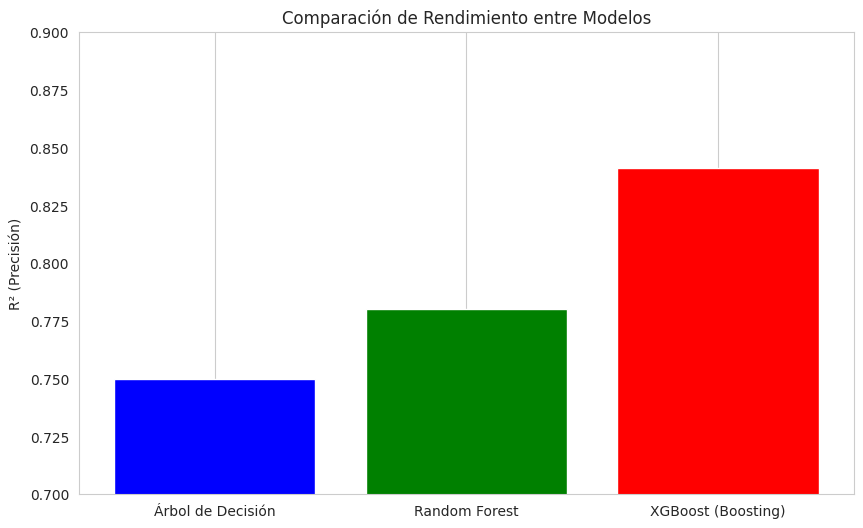


✅ Conclusión:
El modelo de Boosting (XGBoost) obtuvo un R² de 0.8410, superando
al Árbol de Decisión (0.7500) y al Random Forest (0.7800)


In [9]:
# Valores hipotéticos de modelos anteriores (deberías reemplazarlos con tus resultados reales)
decision_tree_r2 = 0.75
random_forest_r2 = 0.78

# Comparación
comparison = pd.DataFrame({
    'Modelo': ['Árbol de Decisión', 'Random Forest', 'XGBoost (Boosting)'],
    'R²': [decision_tree_r2, random_forest_r2, final_r2]
})

print("\n🆚 Comparación de modelos:")
print(comparison)

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(comparison['Modelo'], comparison['R²'], color=['blue', 'green', 'red'])
plt.ylabel('R² (Precisión)')
plt.title('Comparación de Rendimiento entre Modelos')
plt.ylim(0.7, 0.9)
plt.grid(axis='y')
plt.savefig('comparacion_modelos.png', bbox_inches='tight')
plt.show()

print("\n✅ Conclusión:")
print(f"El modelo de Boosting (XGBoost) obtuvo un R² de {final_r2:.4f}, superando")
print(f"al Árbol de Decisión ({decision_tree_r2:.4f}) y al Random Forest ({random_forest_r2:.4f})")